In [115]:
%matplotlib notebook

import os, glob, sys, tqdm
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

sys.path.append('utils')
import step02_novosparc_Wagner2HCR as funcs

from importlib import reload
reload(funcs)

<module 'step02_novosparc_Wagner2HCR' from 'utils\\step02_novosparc_Wagner2HCR.py'>

In [116]:
hpf = 12

hpf_scrna = hpf
if hpf == 12:
    hpf_scrna = 14
    
print(hpf, hpf_scrna)
scrnaseq_folder = os.path.join('..','zebrafish_Wagner_data')
scrnaseq_file = glob.glob(os.path.join(scrnaseq_folder,'*_hvg_%02dhpf.h5ad'%hpf_scrna))[0]

hcr_file = os.path.join('..','HCR_time_course','hpf'+str(hpf)+'_synthetic_HCR.h5')

print(scrnaseq_file)
print(hcr_file)

12 14
..\zebrafish_Wagner_data\WagnerScience2018_hvg_14hpf.h5ad
..\HCR_time_course\hpf12_synthetic_HCR.h5


In [117]:
alpha=1

# Load cells from HCR dataset

Load HCR dataset, filter for high density cells (removing yolk) and adjust name of prdm1->prdm1a

In [118]:
adata_hcr_all = funcs.load_scrnaseq( hcr_file )[0]

# remove cells on the yolk (probably not present in the scrnaseq dataset)
adata_hcr_hires = adata_hcr_all[adata_hcr_all.obs.density>20]
# subsample the cells to speed up computation
# df1 = fluos_df.sample(5000)

num_locs_cells = len(adata_hcr_hires.obs)

# fix name of prdm1 to prdm1a
genes = []
for g in adata_hcr_hires.var_names:
    if g=='prdm1':
        genes.append(g+'a')
    else:
        genes.append(g)
    
adata_hcr_hires.var_names = genes


Remove sox1 from te HCR dataset as it is not present in the scRNAseq data (it was not highly variable!)

In [119]:
gene_markers = adata_hcr_hires.var_names
print(gene_markers)

#remove sox1
removed_genes = ['sox1']
gene_markers = [i for i in gene_markers if i not in removed_genes]

adata_hcr_hires = adata_hcr_hires[:,gene_markers]

print(adata_hcr_hires)
print(adata_hcr_hires.var_names)

Index(['hand2', 'emx3', 'sox10', 'sp5l', 'nkx2.4b', 'pax2a', 'meox1', 'foxa2',
       'ta', 'aldh1a2', 'sox17', 'sox1', 'prdm1a', 'otx2'],
      dtype='object')
View of AnnData object with n_obs × n_vars = 22246 × 13
    obs: 'x', 'y', 'z', 'density', 'h2bgfp'
Index(['hand2', 'emx3', 'sox10', 'sp5l', 'nkx2.4b', 'pax2a', 'meox1', 'foxa2',
       'ta', 'aldh1a2', 'sox17', 'prdm1a', 'otx2'],
      dtype='object')


In [120]:
# rotate to obtain cloud points vertical
# import vedo

old_pos = adata_hcr_hires.obs[['x','y','z']].to_numpy()
color = np.array(adata_hcr_hires[:,['ta']].X[:,0].flatten()) + 0.2*np.array(adata_hcr_hires[:,['nkx2.4b']].X[:,0].flatten())
# old_pos = np.array([[1,1,0]])

import math as m
  
def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])
def Ry(theta):
    return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])
def Rz(theta):
    return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

from scipy.spatial.transform import Rotation as R

r = R.from_matrix(Rx(-40*np.pi/180))
pos = r.apply(old_pos)
r = R.from_matrix(Rz(24*np.pi/180))
pos = r.apply(pos)
# pos[:,1] += 0.15

# half = pos[pos[:,1]>0]
# half[:,1] -= 0.15
# p1 = vedo.Points(old_pos).c('blue').clone()
# p2 = vedo.Points(pos).cmap('hot',color).clone()
# p3 = vedo.Points(half).c('blue').alpha(0.6).clone()
# vedo.show([p2,p3], axes=3)

adata_hcr_hires.obs['x'] = pos[:,0]
adata_hcr_hires.obs['y'] = pos[:,1]
adata_hcr_hires.obs['z'] = pos[:,2]

# # filter only y positive
# adata_hcr_hires = adata_hcr_hires[adata_hcr_hires.obs.y>0]
adata_hcr_hires = adata_hcr_hires[np.abs(adata_hcr_hires.obs.y)<0.7]

# adata_hcr_hires.obs.y -= 0.15

adata_hcr = adata_hcr_hires


Trying to set attribute `.obs` of view, copying.


In [121]:
adata_hcr_hires

View of AnnData object with n_obs × n_vars = 20663 × 13
    obs: 'x', 'y', 'z', 'density', 'h2bgfp'

In [122]:
# # downsample HCR dataset on a grid

# hcr_points = adata_hcr_hires.obs[['x','y','z']].to_numpy()
# grid_size = 0.1
# w_size = 0.15
# bins = np.arange(-1,1.1,grid_size)
# n_min = 5
# synth_hcr_pos = []
# synth_hcr_exp = []
# for i in tqdm.tqdm(range(len(bins)-1)):
#     for j in range(len(bins)-1):
#         for k in range(len(bins)-1):
#             points_in = (hcr_points[:,0]>bins[i])&(hcr_points[:,0]<=bins[i]+w_size)&\
#                     (hcr_points[:,1]>bins[j])&(hcr_points[:,1]<=bins[j]+w_size)&\
#                     (hcr_points[:,2]>bins[k])&(hcr_points[:,2]<=bins[k]+w_size)
#             s = hcr_points[points_in]

#             if (s.shape[0]>n_min):
#                 synth_hcr_pos.append([bins[i],bins[j],bins[k]])
#                 exp = np.array(adata_hcr_hires.X[points_in,:])
#                 synth_hcr_exp.append(np.mean(exp,0))

# synth_hcr_pos = np.array(synth_hcr_pos)
# synth_hcr_exp = np.array(synth_hcr_exp)

In [123]:
# for i in range(synth_hcr_exp.shape[1]):
#     fig = plt.figure(figsize=(8,6))
#     fig.suptitle(gene_markers[i], fontsize=16)
#     ax = fig.add_subplot(121,projection='3d')

#     # ax.imshow(img_gauss[z])
#     p = ax.scatter(
#         synth_hcr_pos[:,0],
#         synth_hcr_pos[:,1],
#         synth_hcr_pos[:,2],
#         c=synth_hcr_exp[:,i],
#         alpha=0.8,
#         cmap='hot'
#     )
#     ax.set_xlim(-1,1)
#     ax.set_ylim(-1,1)
#     ax.set_zlim(-1,1)
#     ax.set_box_aspect([1,1,1])

#     ax = fig.add_subplot(122,projection='3d')

#     # ax.imshow(img_gauss[z])
#     p = ax.scatter(
#         adata_hcr_hires.obs.x,
#         adata_hcr_hires.obs.y,
#         adata_hcr_hires.obs.z,
#         c=adata_hcr_hires[:,gene_markers[i]].X[:,0],
#         alpha=0.1,
#         cmap='hot'
#     )
#     ax.set_xlim(-1,1)
#     ax.set_ylim(-1,1)
#     ax.set_zlim(-1,1)
#     ax.set_box_aspect([1,1,1])



In [124]:
# # contrust anndata

# import anndata as ad

# # construct observation dataframe
# obs = pd.DataFrame({
#     'x':synth_hcr_pos[:,0],
#     'y':synth_hcr_pos[:,1],
#     'z':synth_hcr_pos[:,2],
# })

# # build anndata object and append var_names=name of genes
# adata_hcr = ad.AnnData(synth_hcr_exp, obs=obs)
# adata_hcr.var_names = gene_markers

# print(adata_hcr)
# print(adata_hcr.obs)
# print(adata_hcr.var_names)

<IPython.core.display.Javascript object>


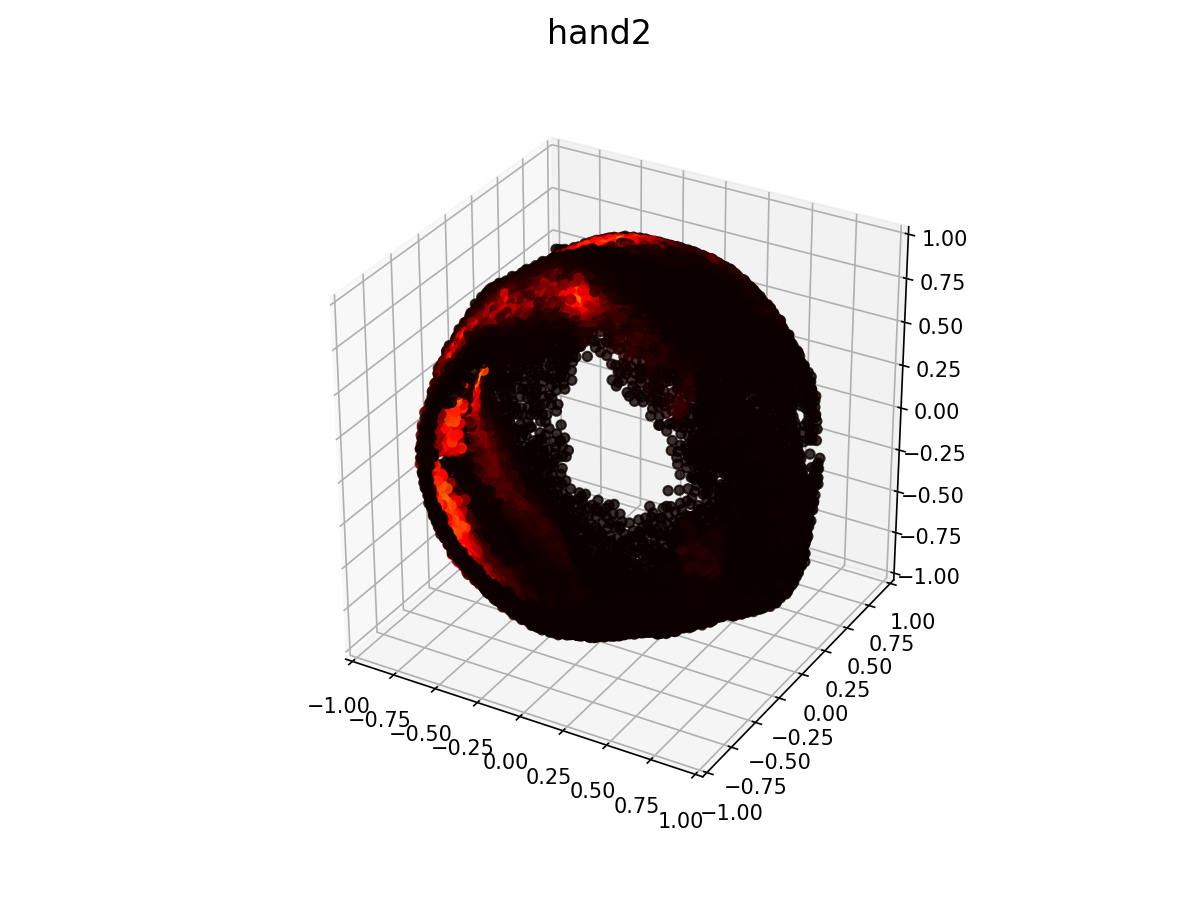

In [125]:
# plot 3D projection to check if all nuclei are more or less found

# fig = plt.figure(figsize=(4,4))
fig = plt.figure(figsize=(8,6))
fig.suptitle('hand2', fontsize=16)
ax = fig.add_subplot(111,projection='3d')

# ax.imshow(img_gauss[z])
p = ax.scatter(
    adata_hcr.obs.x,
    adata_hcr.obs.y,
    adata_hcr.obs.z,
    c=adata_hcr[:,['meox1']].X[:,0],
    alpha=0.8,
    cmap='hot'
)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.set_box_aspect([1,1,1])
#     fig.colorbar(p)

#     set_axes_equal(ax)


# Load scrnaseq dataset

In [126]:
adata_scrna, n_scrna_cells, n_scrna_genes = funcs.load_scrnaseq( scrnaseq_file )

Remove undefined and weird clusters 

In [127]:
print(len(adata_scrna[adata_scrna.obs.TissueName!='NaN']))
print(len(adata_scrna[adata_scrna.obs.ClusterName=='14hpf-mesoderm - blood island']))
print(len(adata_scrna[adata_scrna.obs.ClusterName=='14hpf-germline']))
print(len(adata_scrna[adata_scrna.obs.TissueName=='Germline']))

4001
43
5
5


C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [128]:
adata_scrna = adata_scrna[(adata_scrna.obs.TissueName!='NaN')&(adata_scrna.obs.TissueName!='Germline')]

remove_cluster = ['blood', 'germline']
keep_cell = [all([i not in j for i in remove_cluster]) for j in adata_scrna.obs.ClusterName]
adata_scrna = adata_scrna[keep_cell]

n_scrna_cells = len(adata_scrna.obs)

In [129]:
adata_scrna

View of AnnData object with n_obs × n_vars = 3953 × 5071
    obs: 'n_counts', 'unique_cell_id', 'cell_names', 'library_id', 'batch', 'ClusterID', 'ClusterName', 'TissueID', 'TissueName', 'TimeID'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'ClusterName_colors', 'TissueName_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [131]:
set(adata_scrna.obs.TissueName)

{'Endoderm',
 'Epidermal',
 'Forebrain / Optic',
 'Hindbrain / Spinal Cord',
 'Mesoderm',
 'Midbrain',
 'Neural Crest'}

In [79]:
# %matplotlib inline
# sc.pl.umap(adata_scrna, color=['TissueName'])
# sc.pl.umap(adata_scrna, color=['ClusterName'])

In [80]:
# color_list = ["lightgray", "navy"]
# my_cmap = colors.LinearSegmentedColormap.from_list("mycmap", color_list)

# for g in gene_markers:
#     fig, ax = plt.subplots(figsize=(4,4))
#     sc.pl.umap(adata_scrna, color=g, color_map=my_cmap, ax = ax)

# Rescale HCR values and visualize

In [132]:
adata_hcr.X.shape

(20663, 13)

For all marker genes (i.e. the ones present in the HCR):
- compute min/max values in scRNAseq
- compute 10 and 99.9 percentiles in HCR
- clip values of HCR with its percentiles
- rescale HCR values between 0 and 1
- set all values lower than a otsu threshold to 0 (OPTIONAL)
- rescale values to range of scRNAseq data
- replace the HCR gene expression matrix

In [133]:
from skimage.filters import threshold_otsu

# rescale hcr values to range similar to scrnaseq ones
newX = np.zeros(adata_hcr.X.shape)

for ch in gene_markers:
    # compute min/max values in scRNAseq dataset
    scrna_vals = adata_scrna[:,[ch]].X[:,0]
    scrna_lims = [np.min(scrna_vals), np.max(scrna_vals)]
    
    # compute percentiles in hcr dataset
    hcr_vals = adata_hcr[:,[ch]].X[:,0]
    hcr_lims = np.percentile(hcr_vals[hcr_vals>0],(30, 99))
    print(hcr_lims)
    
    # rescale hcr values to 0-1 clipping outliers
    hcr_vals = (hcr_vals-hcr_lims[0])/(hcr_lims[1]-hcr_lims[0])
    hcr_vals = np.clip(hcr_vals,0,1)
    
    # set to 0 all values below a threshold
#     hcr_thr = 2*threshold_otsu(hcr_vals)
#     hcr_vals[hcr_vals<hcr_thr] = 0.

    # rescale hcr values to min/max of scRNAseq dataset
    hcr_vals = hcr_vals*(scrna_lims[1]-scrna_lims[0])+scrna_lims[0]
    
    # append to new matrix
    gene_idx = list(adata_hcr.var_names).index(ch)
    newX[:,gene_idx] = hcr_vals
    
adata_hcr.X = newX

[ 0.25916666 36.64366703]
[  0.46416667 115.57257576]
[ 24.04316635 930.92683228]
[  2.96749997 279.38703308]
[  2.28208327 210.40078583]
[44.68883286 76.25788284]
[  65.10916901 2727.6357373 ]
[42.48383255 95.41188461]
[42.3441658 94.1342334]
[ 50.40166855 509.32765381]
[41.17716751 50.46843468]
[ 59.71383286 512.12711243]
[ 48.16583328 128.42819641]


C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [134]:
# # subsample hcr dataset
# idxs = list(adata_hcr.obs.sample(4000).index)
# adata_hcr = adata_hcr[[i for i in adata_hcr.obs.index if i in idxs]]

In [135]:
# %matplotlib notebook

# fig = plt.figure(figsize=(4,4))
# # fig.suptitle(gene_markers[i], fontsize=16)
# ax = fig.add_subplot(projection='3d')

# # ax.imshow(img_gauss[z])
# ax.scatter(adata_hcr.obs.x,
#            adata_hcr.obs.y,
#            adata_hcr.obs.z,
#            c=adata_hcr.obs.density,
#            alpha=0.8,
#            cmap='hot'
#           )
# ax.set_box_aspect([1,1,1])
# #     set_axes_equal(ax))

# print(len(adata_hcr.obs))

In [136]:
# # plot 3D projection to check if all nuclei are more or less found
# genes = adata_hcr.var_names

# # fig = plt.figure(figsize=(4,4))
# for i in range(len(genes)):
#     fig = plt.figure(figsize=(4,4))
#     fig.suptitle(genes[i], fontsize=16)
#     ax = fig.add_subplot(projection='3d')

#     # ax.imshow(img_gauss[z])
#     p = ax.scatter(
#         adata_hcr.obs.x,
#         adata_hcr.obs.y,
#         adata_hcr.obs.z,
#         c=adata_hcr[:,genes[i]].X[:,0],
#         alpha=0.1,
#         cmap='hot'
#     )
#     ax.set_box_aspect([1,1,1])
#     fig.colorbar(p)

# #     set_axes_equal(ax)


Compare the distribution of the marker genes in scRNAseq dataset and in HCR dataset.

<IPython.core.display.Javascript object>


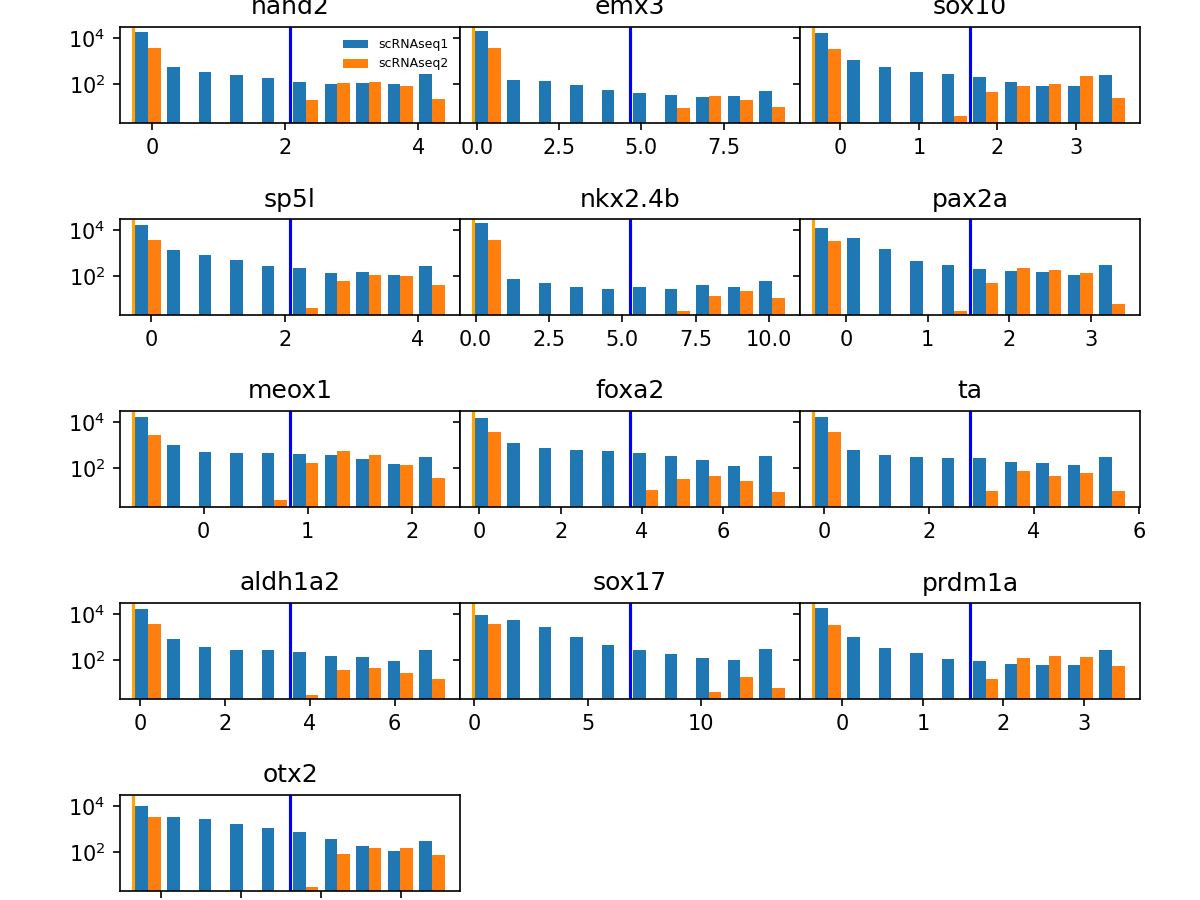

hand2 2.07049298286438 -0.29487923
emx3 4.657700538635254 -0.11482838
sox10 1.652322769165039 -0.350536
sp5l 2.079328775405884 -0.27827275
nkx2.4b 5.257806301116943 -0.090983555
pax2a 1.5176312923431396 -0.4090348
meox1 0.8292348384857178 -0.6793174
foxa2 3.702456474304199 -0.16048712
ta 2.7784225940704346 -0.22058365
aldh1a2 3.5357964038848877 -0.16563243
sox17 6.871830940246582 -0.057972856
prdm1a 1.5847760438919067 -0.36420965
otx2 1.6107484102249146 -0.34774998


In [137]:
from sklearn.cluster import KMeans

reload(funcs)
%matplotlib notebook

fig, ax = funcs.visualize_marker_distribution_adatas(adata_hcr, adata_scrna, 
                                          [i.lower() for i in gene_markers], 
                                          n_cols=3, figsize=(8,6), ylog=True)

for i, g in enumerate(gene_markers):
    g_idx = list(adata_hcr.var_names).index(g)
    hcr_vals = np.array(adata_hcr.X[:,g_idx])
    hcr_thr = (np.max(hcr_vals)+np.min(hcr_vals))/2.
#     hcr_thr = threshold_otsu(hcr_vals)
    ax[i].axvline(hcr_thr, c='blue')

    g_idx = list(adata_scrna.var_names).index(g)
    scrna_vals = np.array(adata_scrna.X[:,g_idx])
    scrna_thr = threshold_otsu(scrna_vals)
    ax[i].axvline(scrna_thr, c='orange')
    
    print(g, hcr_thr, scrna_thr)


Compute how many cells in the HCR data are positive for any of the marker, and will be reasonably mapped.
The cells that are negative to all the markers will be mapped according to their location relative to the marker cells.

NOTE: Uses a simple threshold otsu to define if a cell is positive to a marker, therefore cells that are lowly expressing a certain marker will not be detected.

In [138]:
hcr_thr = {g: 0. for g in gene_markers}

for g in gene_markers:
    g_idx = list(adata_hcr.var_names).index(g)
    hcr_vals = np.array(adata_hcr.X[:,g_idx])
#     hcr_thr[g] = threshold_otsu(hcr_vals)
    hcr_thr[g] = (np.max(hcr_vals)+np.min(hcr_vals))

cell_markers = []
for i, cell in tqdm.tqdm(adata_hcr.obs.iterrows(), total=len(adata_hcr.obs)):
    cell_exp = adata_hcr[cell.name].X[0,:]

    
    is_marker = False
    for g in gene_markers:
        g_idx = list(adata_hcr.var_names).index(g)
        if cell_exp[g_idx]>hcr_thr[g]/2.:
            is_marker = True
            
    if is_marker:
        cell_markers.append(True)
    else:
        cell_markers.append(False)

print('Total number of cells:', len(adata_hcr.obs))
print('Number of marker cells:', np.sum(cell_markers))
print('Num of negative cells:', len(adata_hcr.obs)-np.sum(cell_markers))

100%|██████████████████████████████████████████████████████████████████████████| 20663/20663 [00:10<00:00, 1948.97it/s]

Total number of cells: 20663
Number of marker cells: 7716
Num of negative cells: 12947


Filter cells to only contain marker cells!

In [139]:
# adata_hcr = adata_hcr[cell_markers]

Check how many cells are markers in the scrnaseq dataset

In [140]:
cell_markers = 0
for i, cell in tqdm.tqdm(adata_scrna.obs.iterrows(), total=len(adata_scrna.obs)):
    cell_exp = adata_scrna[cell.name].X[0,:]
    
    is_marker = False
    for g in gene_markers:
        g_idx = list(adata_scrna.var_names).index(g)
        if cell_exp[g_idx]>hcr_thr[g]:
            is_marker = True
            
    if is_marker:
        cell_markers += 1

print('Total number of cells:', len(adata_scrna.obs))
print('Number of marker cells:', cell_markers)
print('Num of negative cells:', len(adata_scrna.obs)-cell_markers)

100%|█████████████████████████████████████████████████████████████████████████████| 3953/3953 [00:32<00:00, 119.83it/s]

Total number of cells: 3953
Number of marker cells: 400
Num of negative cells: 3553


# Perform mapping with novosparc

First, optionally subset the HCR dataset removing some genes that will be then used to evaluate how good the reconstruction is

In [141]:
print(gene_markers)

#remove sox1
evaluation_genes = []
gene_markers1 = [i for i in gene_markers if i not in evaluation_genes]

adata_hcr1 = adata_hcr[:,gene_markers1]

print(adata_hcr1)
print(adata_hcr1.var_names)

['hand2', 'emx3', 'sox10', 'sp5l', 'nkx2.4b', 'pax2a', 'meox1', 'foxa2', 'ta', 'aldh1a2', 'sox17', 'prdm1a', 'otx2']
View of AnnData object with n_obs × n_vars = 20663 × 13
    obs: 'x', 'y', 'z', 'density', 'h2bgfp'
Index(['hand2', 'emx3', 'sox10', 'sp5l', 'nkx2.4b', 'pax2a', 'meox1', 'foxa2',
       'ta', 'aldh1a2', 'sox17', 'prdm1a', 'otx2'],
      dtype='object')


Select the genes that highly differentially expressed in each cluster of the scraseq dataset and the genes that show some correlation with the markers chosen

In [142]:
selected_genes = []
for g in gene_markers:
    selected_genes += [g]
# print(selected_genes)

###
# select differentially expressed genes
###

sc.tl.rank_genes_groups(adata_scrna, 'TissueName', method='wilcoxon', use_raw=False)
# sc.pl.rank_genes_groups(adata1, n_genes=25, sharey=False)

degs = pd.DataFrame(adata_scrna.uns['rank_genes_groups']['names']).head(10)
degs
selected_genes += [i for k in degs.keys() for i in degs[k] ]
selected_genes = list(set(selected_genes))
# print(selected_genes)
   
###
# select genes that correlate highly with the markers
###

r = np.corrcoef(adata_scrna.X, rowvar=False)
## print(r.shape)
## %matplotlib notebook
## plt.figure()
## plt.imshow(r, cmap='RdBu', clim=(-0.01,0.01))
## plt.colorbar()

for gene_marker in gene_markers:
    i = list(adata_scrna.var_names).index(gene_marker)
#     print(gene_marker, i)
    idxs = list(np.where(np.abs(r[:,i])>0.25)[0])
#     print(idxs)
    idxs.remove(i)
#     print(adata1.var_names[idxs])
    for gene in adata_scrna.var_names[idxs]:
        if gene not in selected_genes:
            selected_genes += [gene]
        
print(selected_genes)

adata_scrna.var['selected_gene'] = [i in selected_genes for i in adata_scrna.var_names]

# adata_scrna = adata_scrna[:, selected_genes]


Trying to set attribute `.uns` of view, copying.
C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\scanpy\tools\_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


['krt8', 'prtga', 'zfp36l1a', 'nkx2.4b', 'otx2', 'actc1a', 'tagln2', 'fosab', 'mdka', 'si:dkey-261h17.1', 'aldh1a2', 'eng2b', 'marcksl1b', 'myh9a', 'hspb1', 'tfap2a', 'foxc1a', 'cd9b', 'fn1b', 'sox11a', 'krt4', 'pltp', 'sox1b', 'cfl1l', 'sp5l', 'ta', 'si:ch211-201m7.3', 'pfn1', 'ptmaa', 'krt18', 'gfap', 'meox1', 'LOC100334443', 'hand2', 'cdh1', 'ednrab', 'sox10', 'LOC100537766', 'wu:fb77a09', 'cyt1', 'epcam', 'id1', 'foxp4', 'zbtb16a', 'slc1a3a', 'sox17', 'sox3', 'foxa2', 'si:ch211-156j16.1', 'bcam', 'emx3', 'mdkb', 'cyp2p6', 'prdm1a', 'zic2b', 'id2a', 'cldni', 'nbas', 'sox2', 'tuba8l2', 'cbr1', 'col15a1b', 'zfhx4', 'nova2', 'sox19a', 'pax2a', 'LOC103910167', 'tuba1a', 'cldn7b', 'six3b', 'hm:zewp0073', 'f11r.1', 'tuba1c', 'bnc1', 'fn1a', 'gata2a', 'gata3', 'gata5', 'lama5', 'pcdh10a', 'sfrp5', 'si:dkey-207j16.2', 'sult2st1', 'tbx2a', 'fezf2', 'rspo3', 'LOC103908616', 'LOC103910711', 'ets1', 'fam212aa', 'fam46ba', 'foxd3', 'kalrnb', 'nr4a2b', 'nrp2a', 'pde4ba', 'rgs5b', 's100t', 'sfrp2'

In [143]:
adata_scrna

AnnData object with n_obs × n_vars = 3953 × 5071
    obs: 'n_counts', 'unique_cell_id', 'cell_names', 'library_id', 'batch', 'ClusterID', 'ClusterName', 'TissueID', 'TissueName', 'TimeID'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'selected_gene'
    uns: 'ClusterName_colors', 'TissueName_colors', 'hvg', 'neighbors', 'pca', 'umap', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [144]:
from importlib import reload  
reload(funcs)

num_locs_cells = len(adata_hcr1.obs)
tol=1e-4
epsilon=5e-3
num_neighbors_source=10
num_neighbors_target=10

adata_mapped = funcs.scrnaseq2locs_adatas(
                                    adata_hcr1, 
                                    gene_markers1, 
                                    adata_scrna, 
                                    num_locs_cells, 
                                    n_scrna_cells, 
                                    alpha, 
                                    tol=tol, 
                                    epsilon=epsilon,
                                    num_neighbors_source=num_neighbors_source, 
                                    num_neighbors_target=num_neighbors_target,
                                    space_keys=["x", "y", "z"]
                                )


Number of cells in marker dataset: 20663
Number of cells in scRNAseq dataset: 3953
Number of genes in scRNAseq dataset: 5071
All seems good.


Setup reconstruction...

Setting up for reconstruction ... 

C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


done ( 280.07 seconds )

Reconstructing with alpha=1
It.  |Err.        
-------------------
    0|1.031283e-03|
Done.
Transporting scRNA values onto locations


### Rescale OT values to the range similar to the scRNAseq dataset

In [145]:
gene_names = adata_mapped.var_names

for g in tqdm.tqdm(gene_names):
    g_idx = list(adata_mapped.var_names).index(g)

    scrna_vals = adata_scrna.X[:,g_idx].copy()
    scrna_lims = [np.min(scrna_vals), np.max(scrna_vals)]
    
    hcr_vals = adata_mapped.X[:,g_idx].copy()
    (mins, maxs) = np.percentile(hcr_vals, (3, 99))
    
    hcr_vals_new = (hcr_vals-np.array(mins))/(np.array(maxs)-np.array(mins))
    hcr_vals_new = np.clip(hcr_vals_new,0,1)
    hcr_vals_new = hcr_vals_new*(scrna_lims[1]-scrna_lims[0])+scrna_lims[0]
        
    adata_mapped.X[:,g_idx] = hcr_vals_new
    
# for g in tqdm.tqdm(selected_genes):
#     g_idx = list(adata_mapped.var_names).index(g)

#     hcr_vals = adata_mapped.X[:,g_idx].copy()
    
#     hcr_thr = threshold_otsu(hcr_vals)
#     hcr_vals[hcr_vals<hcr_thr] = np.min(hcr_vals)

#     adata_mapped.X[:,g_idx] = hcr_vals


100%|█████████████████████████████████████████████████████████████████████████████| 5071/5071 [00:05<00:00, 885.26it/s]


In [146]:
adata_mapped.var

,highly_variable,means,dispersions,dispersions_norm,mean,std,selected_gene
index,,,,,,,
LOC100000168,True,0.095291,1.441228,1.068962,0.203714,0.769320,False
LOC100000332,True,0.294969,2.019879,1.250390,0.574796,1.292339,False
LOC100000352,True,0.014053,1.398221,0.964255,0.009177,0.167619,False
LOC100000748,True,0.041768,1.331175,0.801019,0.076141,0.481966,False
LOC100000753,True,0.026312,1.279732,0.675772,0.027511,0.289677,False
...,...,...,...,...,...,...,...
zranb3,True,0.111716,1.275994,0.666673,0.133516,0.640881,False
zufsp,True,0.092182,1.248651,0.600100,0.111845,0.583729,False
zwi,True,0.038608,1.409021,0.990547,0.212127,0.846332,True


### Visualize distribution of all genes and compare with scRNAseq dataset

C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


<IPython.core.display.Javascript object>


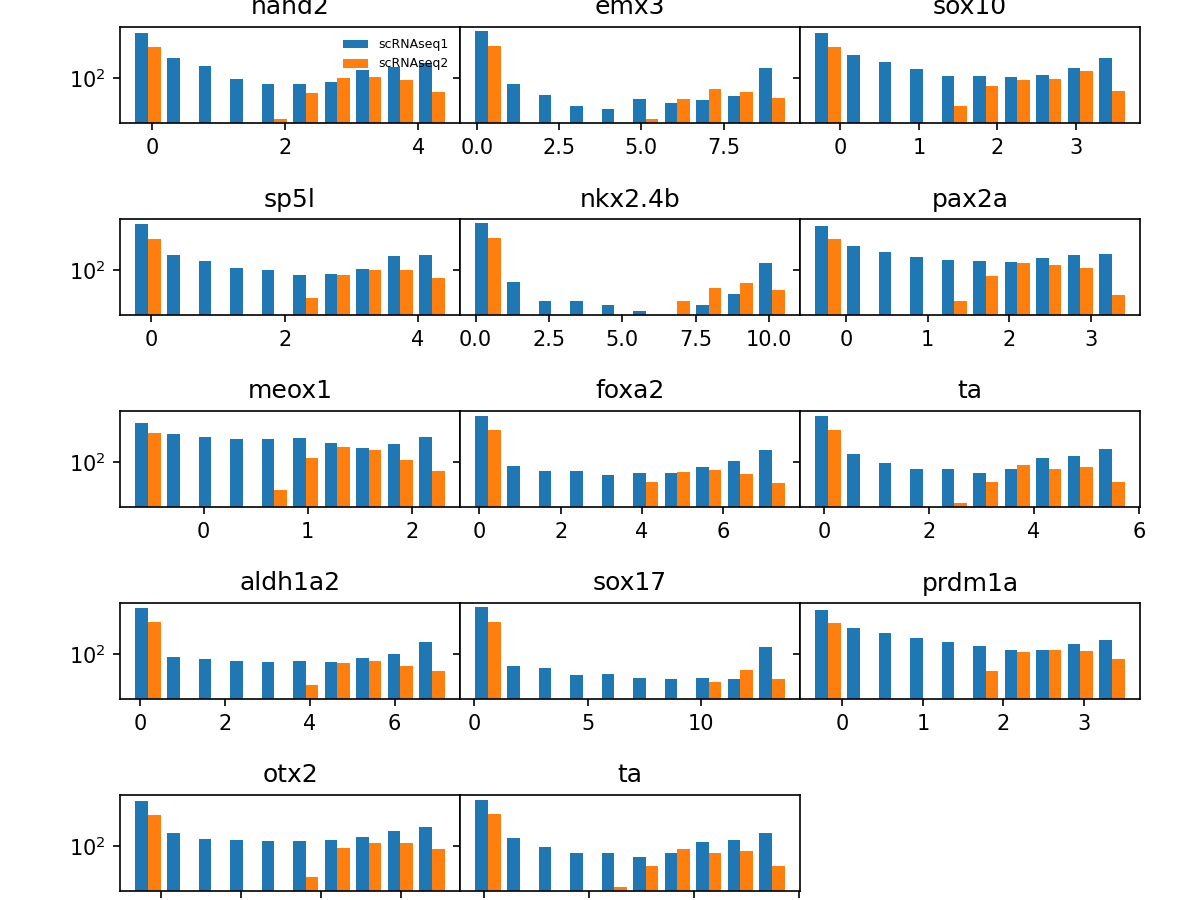

In [147]:
reload(funcs)
%matplotlib notebook

# fig = funcs.visualize_marker_distribution_adatas(adata_mapped[:,adata_mapped.var.selected_gene], 
#                                           adata_scrna[:,adata_scrna.var.selected_gene], 
#                                           list(adata_mapped[:,adata_mapped.var.selected_gene].var_names), 
#                                           gene_highlight=gene_markers, 
#                                           n_cols=5, figsize=(8,28), ylog=True)

fig, ax = funcs.visualize_marker_distribution_adatas(adata_mapped[:,gene_markers1+['ta']], 
                                                     adata_scrna[:,gene_markers1+['ta']], 
                                          list(adata_mapped[:,gene_markers1+['ta']].var_names), 
                                          n_cols=3, figsize=(8,6), ylog=True)


### Visualize spatial gene expression mapped

In [97]:
# from importlib import reload  
# reload(funcs)

# fig = funcs.visualize_3d(adata_mapped, [i.lower() for i in gene_markers], ncols=3, figsize=(12,18))

In [98]:
# %matplotlib notebook
# from importlib import reload  
# reload(funcs)

# fig = funcs.visualize_3d(adata_mapped1, selected_genes, ncols=4, figsize=(8,48), alpha=0.9)

<IPython.core.display.Javascript object>


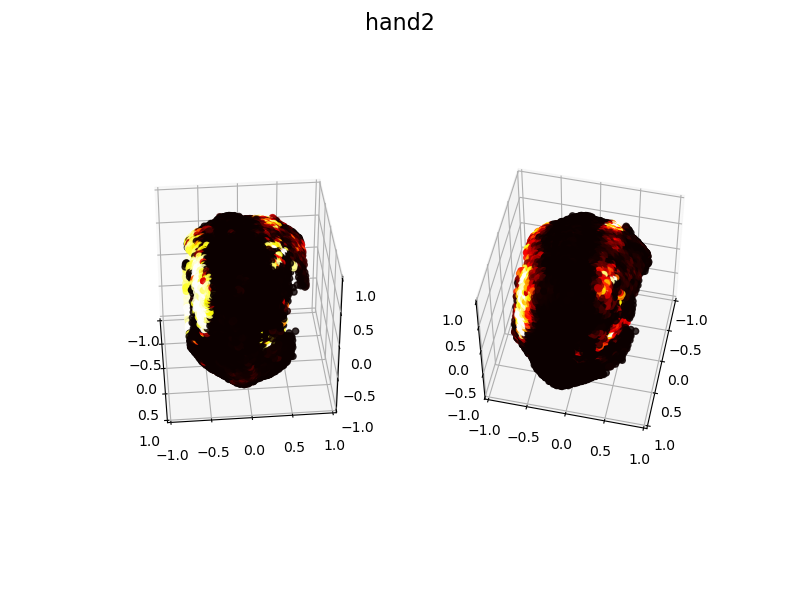

<IPython.core.display.Javascript object>


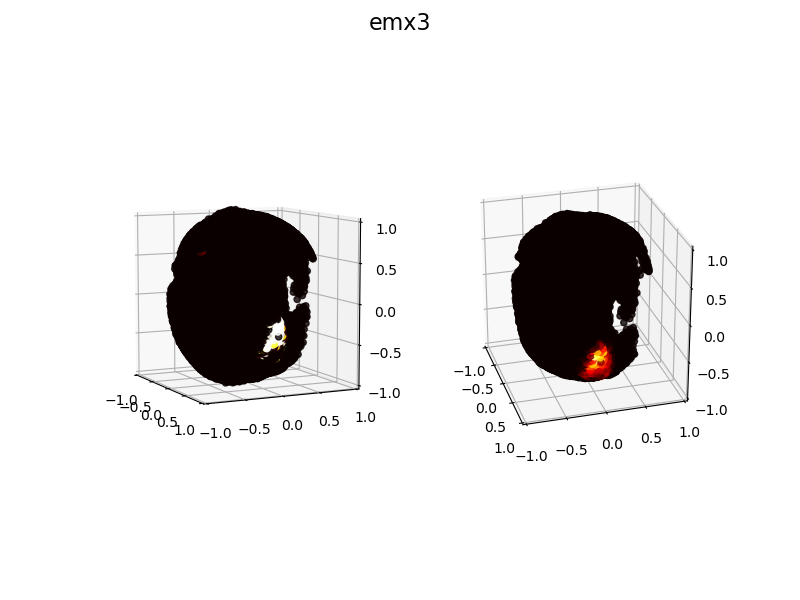

<IPython.core.display.Javascript object>


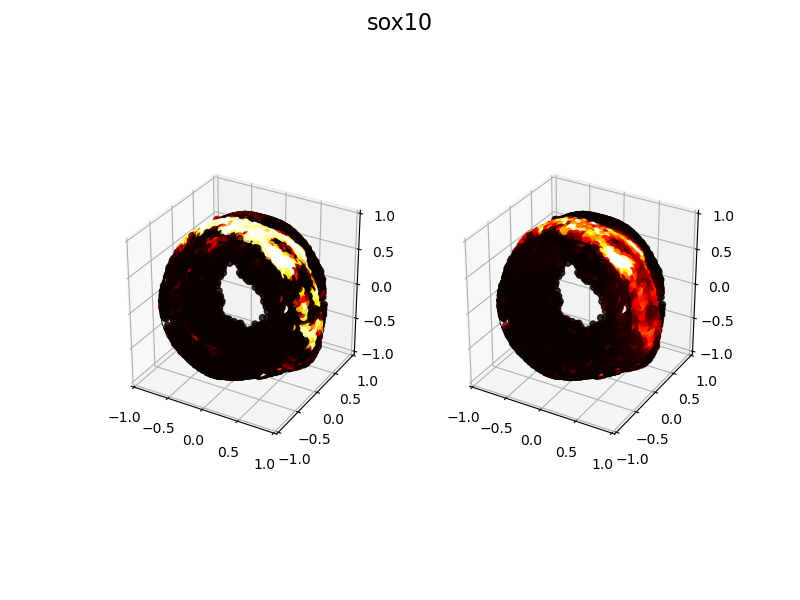

<IPython.core.display.Javascript object>


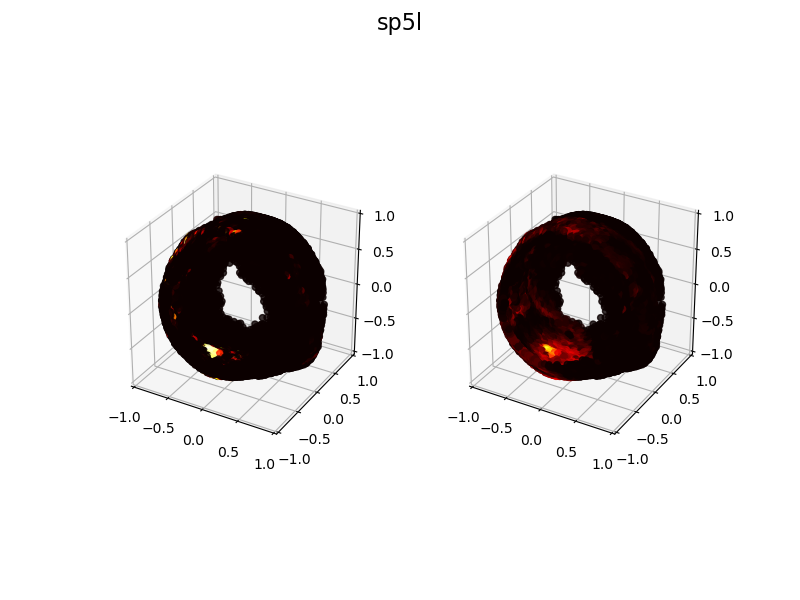

<IPython.core.display.Javascript object>


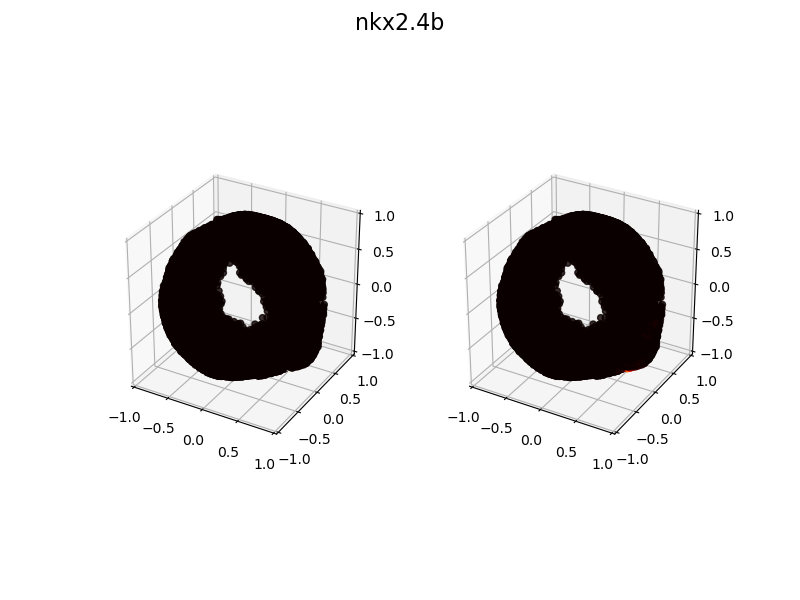

<IPython.core.display.Javascript object>


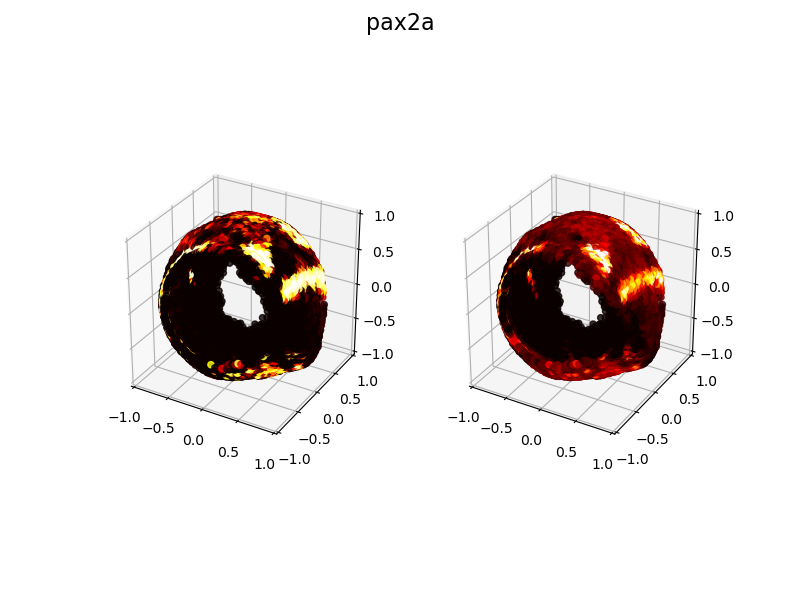

<IPython.core.display.Javascript object>


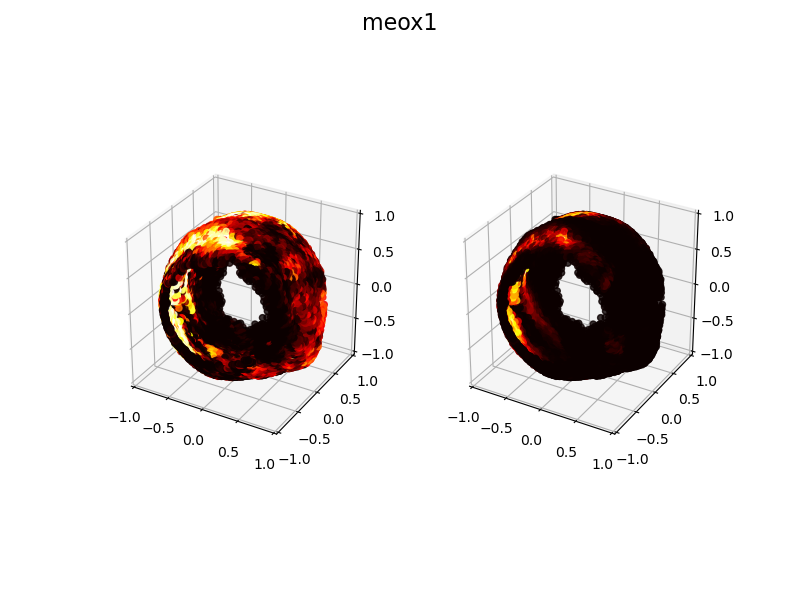

<IPython.core.display.Javascript object>


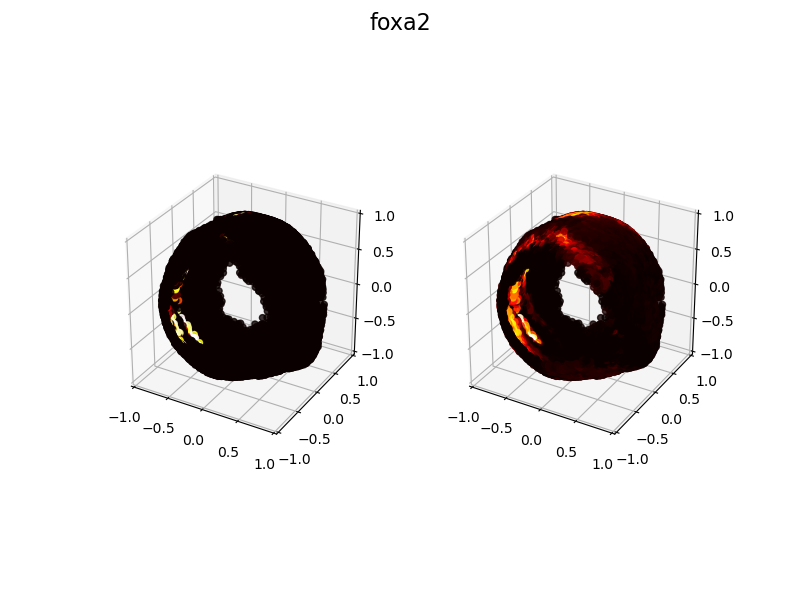

<IPython.core.display.Javascript object>


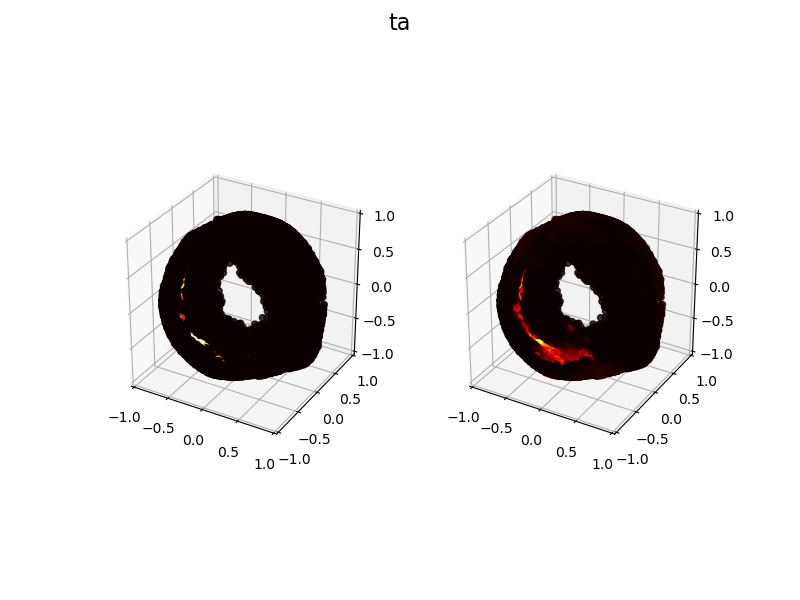

<IPython.core.display.Javascript object>


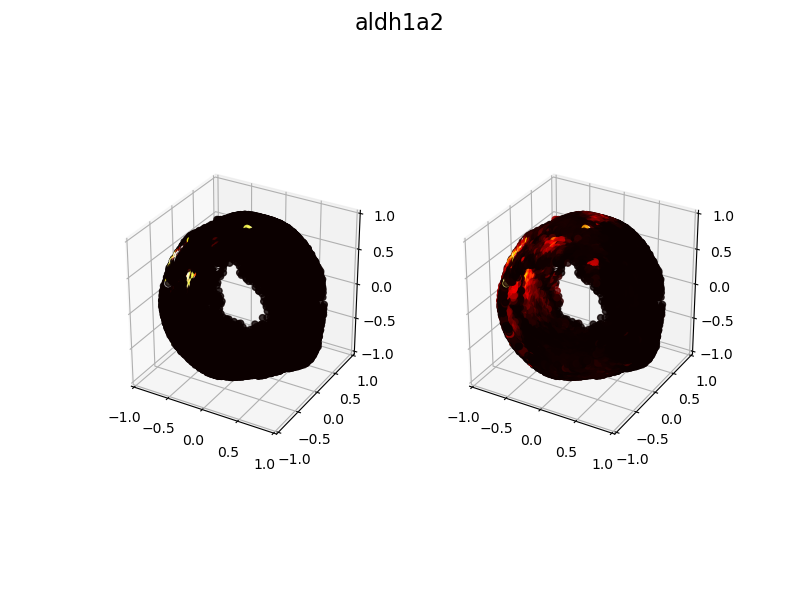

<IPython.core.display.Javascript object>


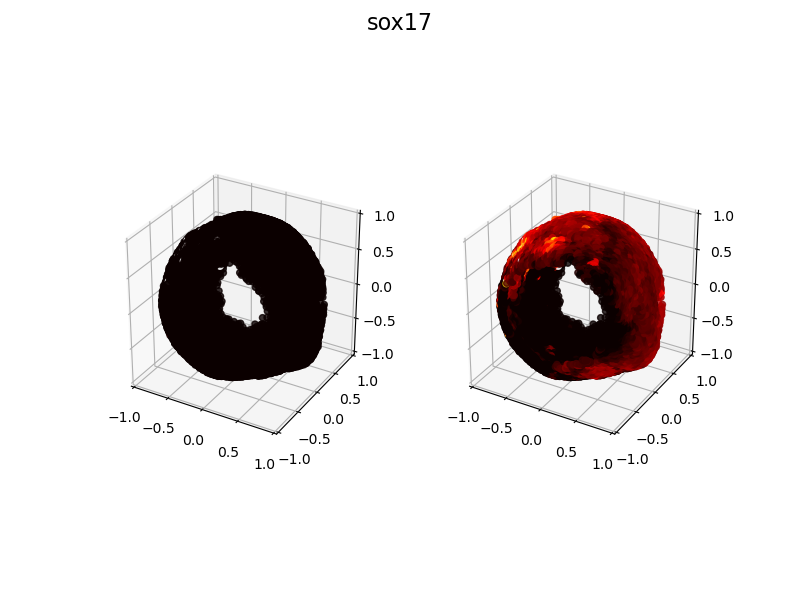

<IPython.core.display.Javascript object>


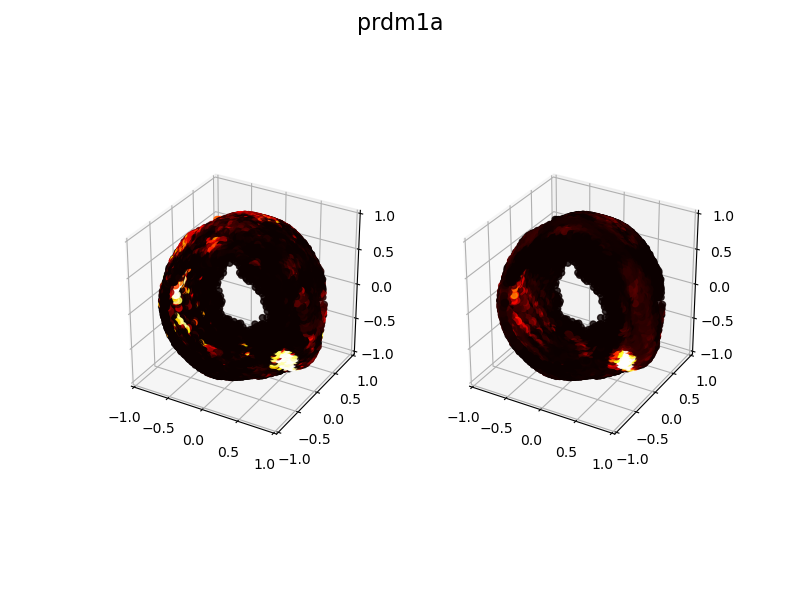

<IPython.core.display.Javascript object>


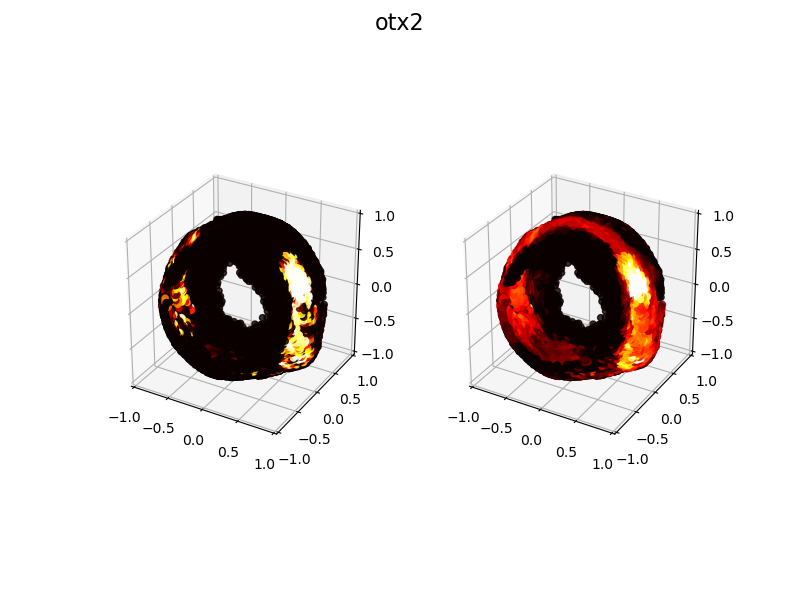

<IPython.core.display.Javascript object>


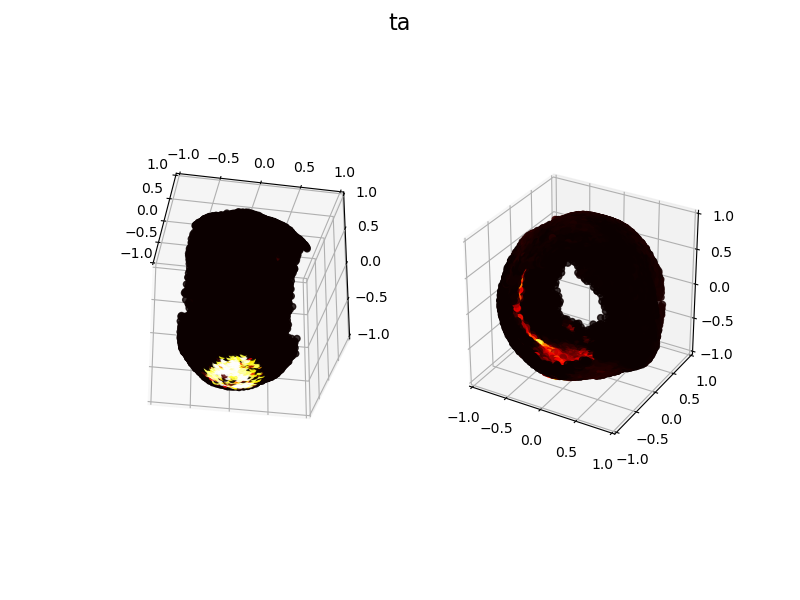

In [103]:
# plot 3D projection to check if all nuclei are more or less found
genes = gene_markers+['ta']

# fig = plt.figure(figsize=(4,4))
for i in range(len(genes)):
    fig = plt.figure(figsize=(8,6))
    fig.suptitle(genes[i], fontsize=16)
    ax = fig.add_subplot(121,projection='3d')

    # ax.imshow(img_gauss[z])
    p = ax.scatter(
        adata_mapped.obs.x,
        adata_mapped.obs.y,
        adata_mapped.obs.z,
        c=adata_mapped[:,genes[i]].X[:,0],
        alpha=0.8,
        cmap='hot'
    )
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    ax.set_box_aspect([1,1,1])
    
    ax = fig.add_subplot(122,projection='3d')

    # ax.imshow(img_gauss[z])
    p = ax.scatter(
        adata_hcr.obs.x,
        adata_hcr.obs.y,
        adata_hcr.obs.z,
        c=adata_hcr[:,genes[i]].X[:,0],
        alpha=0.8,
        cmap='hot'
    )
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    ax.set_box_aspect([1,1,1])
#     fig.colorbar(p)

#     set_axes_equal(ax)


# Run umap

In [104]:
# print('neighbors')
# sc.pp.neighbors(adata_mapped, n_neighbors=20, n_pcs=20)
# print('running umap')
# sc.tl.umap(adata_mapped, min_dist=0.2)

In [105]:
# adata_mapped.obs = adata_mapped.obs.rename(columns={
#     'hand2':'ch-hand2', 
#     'emx3':'ch-emx3', 
#     'sox10':'ch-sox10', 
#     'sp5l':'ch-sp5l' ,
#     'nkx2.4b':'ch-nkx2.4b'})

In [106]:
# for g in gene_markers:
#     sc.pl.umap(adata_mapped, color=g)

# Map back to full resolution dataset

In [107]:
# adata_mapped

In [108]:
# adata_hcr_hires

In [109]:
# from sklearn.neighbors import NearestNeighbors

# ref = np.array(adata_mapped.obs[['x','y','z']].to_numpy())
# query = np.array(adata_hcr_hires.obs[['x','y','z']].to_numpy())

# nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(ref)
# distances, indices = nbrs.kneighbors(query)

In [110]:
# X = np.array(adata_mapped.X)[indices]

# print(np.mean(X,1).shape)

In [111]:
# X = np.mean(np.array(adata_mapped.X)[indices],1)
# obs = adata_hcr_hires.obs
# var = adata_mapped.var


In [112]:
# adata_mapped_hires = ad.AnnData(X, obs=obs, var=var)


In [113]:
# adata_mapped_hires

In [114]:
# # plot 3D projection to check if all nuclei are more or less found
# genes = gene_markers

# # fig = plt.figure(figsize=(4,4))
# for i in range(len(genes)):
#     fig = plt.figure(figsize=(8,6))
#     fig.suptitle(genes[i], fontsize=16)
#     ax = fig.add_subplot(121,projection='3d')

#     # ax.imshow(img_gauss[z])
#     p = ax.scatter(
#         adata_mapped_hires.obs.x,
#         adata_mapped_hires.obs.y,
#         adata_mapped_hires.obs.z,
#         c=adata_mapped_hires[:,genes[i]].X[:,0],
#         alpha=0.1,
#         cmap='hot'
#     )
#     ax.set_xlim(-1,1)
#     ax.set_ylim(-1,1)
#     ax.set_zlim(-1,1)
#     ax.set_box_aspect([1,1,1])
    
#     ax = fig.add_subplot(122,projection='3d')

#     # ax.imshow(img_gauss[z])
#     p = ax.scatter(
#         adata_hcr_hires.obs.x,
#         adata_hcr_hires.obs.y,
#         adata_hcr_hires.obs.z,
#         c=adata_hcr_hires[:,genes[i]].X[:,0],
#         alpha=0.1,
#         cmap='hot'
#     )
#     ax.set_xlim(-1,1)
#     ax.set_ylim(-1,1)
#     ax.set_zlim(-1,1)
#     ax.set_box_aspect([1,1,1])
# #     fig.colorbar(p)

# #     set_axes_equal(ax)


# Save mapped data

In [148]:
alpha_str = str(alpha).replace('.','')

missing_gene = ''
for i in adata_hcr.var_names:
    if i not in adata_hcr1.var_names:
        missing_gene += i+'-'
missing_gene = missing_gene[:-1]

mapped_name = os.path.join(os.path.split(hcr_file)[0], 
                           'mapped_grid_hires_hpf'+str(hpf)+\
                           '_nlocs-'+str(num_locs_cells)+'_alpha-'+alpha_str+\
                           '_tol-'+str(tol)+'_eps-'+str(epsilon)+\
                           '_nS-'+str(num_neighbors_source)+\
                           '_nT-'+str(num_neighbors_target)+
                           '_NO-'+missing_gene+'.h5ad')
adata_mapped.write(filename=mapped_name)